## Model: ISS (International Space Station)

$$
\begin{array}{lcl}
   \dot{x}(t) &=& Ax(t) + Bu(t) \\
   y(t) & = & C x(t)
\end{array}
$$

We assume that $u(t) \in \mathcal{U}$ and $u'(t) = 0$. For time-varying case is considered in  https://juliareach.github.io/ReachabilityAnalysis.jl/dev/models/ISS/

In [63]:
using ReachabilityAnalysis, JLD2
using ReachabilityAnalysis: add_dimension

examples_dir = normpath("/home/mforets/.julia/dev/ReachabilityAnalysis/examples")
ISS_path = joinpath(examples_dir, "ISS", "ISS.jld2")

@load ISS_path C;
const C3 = C[3, :]; # variable y₃
const C3_ext = vcat(C3, fill(0.0, 3));
LazySets.set_ztol(Float64, 1e-15);

In [64]:
function ISSC01()
    @load ISS_path A B

    A_ext = add_dimension(A, 3)
    A_ext[1:270, 271:273] = B

    U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.])
    X0 = BallInf(zeros(size(A, 1)), 0.0001)
    X0 = X0 * U
    return @ivp(x' = A_ext*x, x(0) ∈ X0)
end

ISSC01 (generic function with 1 method)

In [65]:
prob = ISSC01()

const Ae = state_matrix(prob)

typeof(prob) # x' = Ax

InitialValueProblem{LinearContinuousSystem{Float64,SparseMatrixCSC{Float64,Int64}},CartesianProduct{Float64,BallInf{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}}

In [66]:
statedim(prob)

273

It is a 273x273 linear system, $x'(t) = A_ex(t)$.

In [67]:
X0 = initial_state(prob)

dim(X0)

273

In [68]:
typeof(X0)

CartesianProduct{Float64,BallInf{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}

In [69]:
X0h = convert(Hyperrectangle, X0)
sum(!iszero, radius_hyperrectangle(X0h))

273

The box is not flat on any dimension, hence the number of vertices is $2^{273}$.

## Flowpipe computation of the observable $y(t) = Cx(t)$

In [142]:
GC.gc()

In [143]:
dirs = CustomDirections([C3_ext, -C3_ext]);
prob_ISSC01 = ISSC01();

# only the center
prob_ISSC01_0 = IVP(system(prob_ISSC01), center(X0h))

@time sol_ISSC01 = solve(prob_ISSC01_0, T=100.0, alg=LGG09(δ=0.02, template=dirs, sparse=false, cache=false));
@time πsol_ISSC01 = project(sol_ISSC01, C3_ext);

# second time
@time sol_ISSC01 = solve(prob_ISSC01_0, T=100.0, alg=LGG09(δ=0.02, template=dirs, sparse=false, cache=false));
@time πsol_ISSC01 = project(sol_ISSC01, C3_ext);

sol = πsol_ISSC01;

  0.376489 seconds (25.72 k allocations: 220.417 MiB, 1.00% gc time)
  0.032068 seconds (80.01 k allocations: 78.126 MiB, 38.13% gc time)
  0.297722 seconds (25.72 k allocations: 220.417 MiB, 1.12% gc time)
  0.037219 seconds (80.01 k allocations: 78.126 MiB, 34.45% gc time)


In [144]:
using Plots, Plots.PlotMeasures
using LazySets: center

fig = Plots.plot();
Plots.plot!(fig, πsol_ISSC01, vars=(0, 1), linecolor=:blue, color=:blue, alpha=0.8, lw=1.0, xlab="t", ylab="y₃")
fig

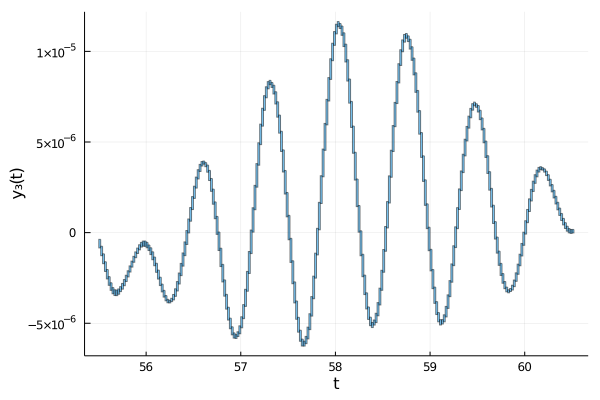

In [145]:
plot(πsol_ISSC01(55.5 .. 60.5), vars=(0, 1), xlab="t", ylab="y₃(t)")

## Comparison with a linear ODE solver

In [146]:
using DifferentialEquations
const DE = DifferentialEquations
using SparseArrays

In [147]:
function iss!(dx, x, p, t)
    dx .= Ae * x
end

iss! (generic function with 1 method)

In [148]:
c0 = center(X0h);
c0s = sparse(c0)

typeof(Ae), typeof(c0s)

(SparseMatrixCSC{Float64,Int64}, SparseVector{Float64,Int64})

In [149]:
GC.gc()

In [150]:
probDE = ODEProblem(iss!, c0, (0.0, 100.0))
@time solDE = DE.solve(probDE, Tsit5(), reltol=1e-8, abstol=1e-8);
@time solDEproj = [dot(C3_ext, x) for x in solDE.u];

# second time
@time solDE = DE.solve(probDE, Tsit5(), reltol=1e-8, abstol=1e-8);
@time solDEproj = [dot(C3_ext, x) for x in solDE.u];

  1.488147 seconds (2.41 M allocations: 257.049 MiB, 1.10% gc time)
  0.034968 seconds (72.47 k allocations: 3.775 MiB)
  0.076607 seconds (70.77 k allocations: 150.066 MiB, 17.67% gc time)
  0.049426 seconds (72.47 k allocations: 3.776 MiB)


In [151]:
plot(sol, vars=(0, 1), lab="Flowpipe (initial set)")
plot!(solDE.t, solDEproj, vars=(0, 1), lab="One trajectory")

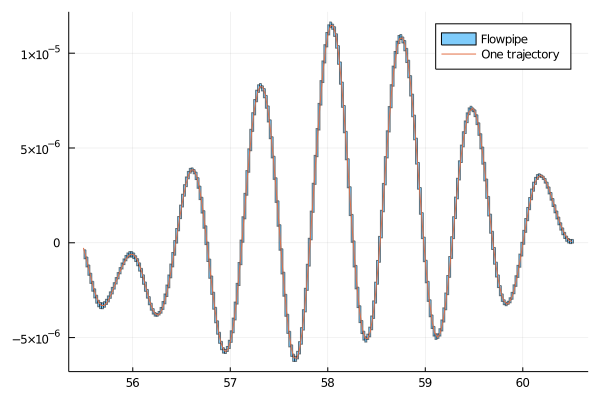

In [152]:
a = findfirst(ti -> ti > 55.5, solDE.t)-1
b = findfirst(ti -> ti > 60.5, solDE.t);

plot(sol(55.5 .. 60.5), vars=(0, 1), lab="Flowpipe")
plot!(solDE.t[a:b], solDEproj[a:b], vars=(0, 1), lab="One trajectory")

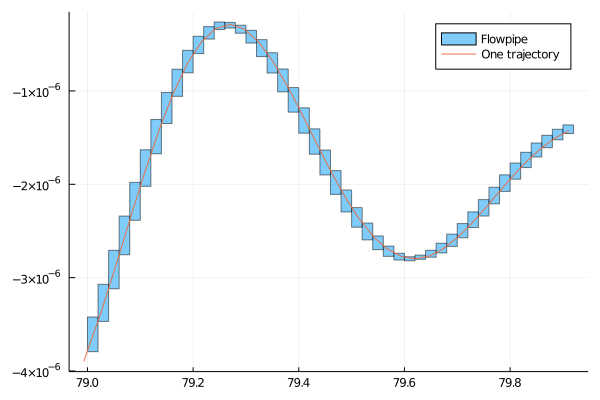

In [153]:
a = findfirst(ti -> ti > 79.0, solDE.t)-1
b = findfirst(ti -> ti > 79.9, solDE.t)

plot(sol(79.0 .. 79.9), vars=(0, 1), lab="Flowpipe")
plot!(solDE.t[a:b], solDEproj[a:b], vars=(0, 1), lab="One trajectory")

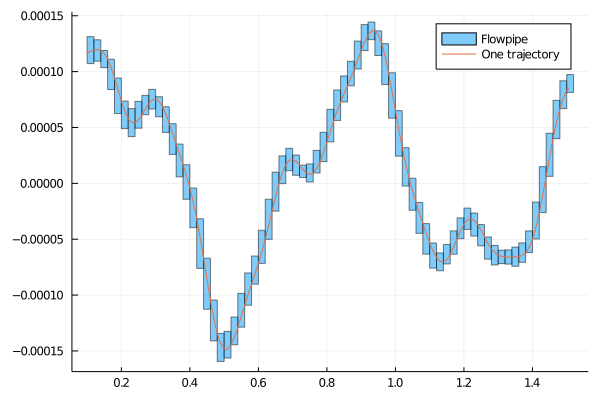

In [154]:
a = findfirst(ti -> ti > 0.1, solDE.t)-1
b = findfirst(ti -> ti > 1.5, solDE.t)

plot(sol(0.1 .. 1.5), vars=(0, 1), lab="Flowpipe")
plot!(solDE.t[a:b], solDEproj[a:b], vars=(0, 1), lab="One trajectory")

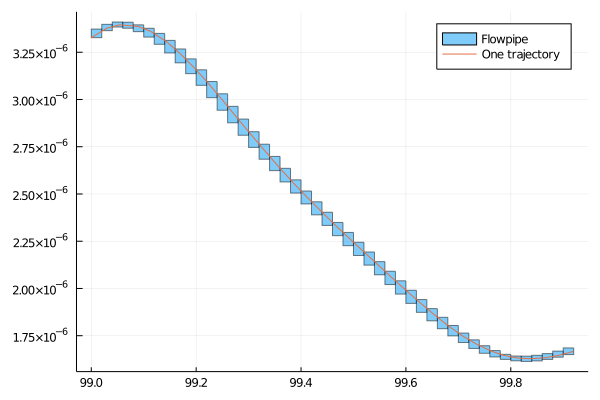

In [155]:
a = findfirst(ti -> ti > 99.0, solDE.t)-1
b = findfirst(ti -> ti > 99.9, solDE.t)

plot(sol(99.0 .. 99.9), vars=(0, 1), lab="Flowpipe")
plot!(solDE.t[a:b], solDEproj[a:b], vars=(0, 1), lab="One trajectory")